In [691]:
# Data update functionality
import os
from pathlib import Path
from fabric import ThreadingGroup,Connection
from fabric.transfer import Transfer

# global configuration parameters
experiment_type = "random"
exploration_name = "Exploration_3"

hosts = {}
with open(str(Path("~/.ssh/config").expanduser()),'r') as f:
    for line in f.readlines():
        if "HostName" in line:
            cleaned_ip = line.strip(" ").split(" ")[2].strip('\n')
            if cleaned_ip != r'None':
                ip = cleaned_ip
            else:
                host = None
                ip = None
        if "Host" in line and "HostName" not in line:
            cleaned_host = line.split(" ")[1].strip("\n")
            if "ug" not in cleaned_host:
                host = cleaned_host
            else:
                host = None
                ip = None
        if host is not None and ip is not None:
            hosts[host]= ip

key_file_loc = "/Users/sfeygi/.ssh/beam_competitions_key.pem"
dest_root = "/Users/sfeygi/current_code/others/prize_starter_kit/search-output/{}/{}/".format(exploration_name,experiment_type)

def connect_parallel(hosts,key_file_loc):
    return ThreadingGroup(*hosts,user='ubuntu',connect_kwargs={"key_filename":[key_file_loc]})

def connect_single(host, key_file_loc):
    return Connection(host,user='ubuntu',connect_kwargs={"key_filename":[key_file_loc]})

def run(cmd, connection):
    return connection.run(cmd)

def run_n(cmd, connections):
    return [run(cmd,connection) for connection in connections]

def rsync_results(hostname, host_ip, key_file_loc, dest_root,exploration_name,experiment_type):
    experiment_type = 'random_inputs' if experiment_type == 'random' else experiment_type
    return os.system(
        'rsync -avz -e "ssh -i {key_file_loc}" ubuntu@{host_ip}:/home/ubuntu//Uber-Prize-Starter-Kit/search-output-{exploration_name}-{experiment_type}/ {dest_root}{hostname} --exclude="*/ITERS/" --exclude="*/output*" --exclude="*/competition/viz/" --exclude="*/summaryStats/"'.format(
            exploration_name=exploration_name,experiment_type=experiment_type,dest_root=dest_root,key_file_loc=key_file_loc, hostname=hostname, host_ip=host_ip))

# global other
host_names = ["host{}".format(str(i + 1)) for i in range(len(hosts))]
connection = connect_parallel(hosts,key_file_loc)

In [693]:
# try:
#     run('cd /home/ubuntu/Uber-Prize-Starter-Kit/utilities &&  \
#         git pull origin vgv/#55-adapt_ramdom_search', connection)
# except UnexpectedExit:
#     print("Already pulled in latest!")
# Ensure that docker image on server is latest (somewhat orthogonal to this notebook, but leaving here for now)
run('docker pull beammodel/beam-competition:0.0.1-SNAPSHOT',connection)


0.0.1-SNAPSHOT: Pulling from beammodel/beam-competition
Digest: sha256:a6c8b5662cb75358e934ea719fde8ec41575e353eaa780788d757040d570e29b
Status: Image is up to date for beammodel/beam-competition:0.0.1-SNAPSHOT
0.0.1-SNAPSHOT: Pulling from beammodel/beam-competition
Digest: sha256:a6c8b5662cb75358e934ea719fde8ec41575e353eaa780788d757040d570e29b
Status: Image is up to date for beammodel/beam-competition:0.0.1-SNAPSHOT
0.0.1-SNAPSHOT: Pulling from beammodel/beam-competition
Digest: sha256:a6c8b5662cb75358e934ea719fde8ec41575e353eaa780788d757040d570e29b
Status: Image is up to date for beammodel/beam-competition:0.0.1-SNAPSHOT
0.0.1-SNAPSHOT: Pulling from beammodel/beam-competition
Digest: sha256:a6c8b5662cb75358e934ea719fde8ec41575e353eaa780788d757040d570e29b
Status: Image is up to date for beammodel/beam-competition:0.0.1-SNAPSHOT
0.0.1-SNAPSHOT: Pulling from beammodel/beam-competition
Digest: sha256:a6c8b5662cb75358e934ea719fde8ec41575e353eaa780788d757040d570e29b
Status: Image is up to d

{<Connection host=54.184.118.222 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=54.218.172.167 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=52.13.145.44 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=34.210.22.65 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=54.218.29.151 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=52.89.179.9 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=54.191.161.231 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=52.38.92.77 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>}

In [694]:
# Pull latest results from servers
[rsync_results(hostname, host_ip, key_file_loc,dest_root,exploration_name,experiment_type) for hostname, host_ip in hosts.items()]

[0, 0, 0, 0, 0, 0, 0, 0]

In [695]:
import pandas as pd
import seaborn as sns
# import dask.dataframe as dd
import numpy as np
from collections import defaultdict
import re
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [696]:
%matplotlib inline

In [697]:
# Parsing utilities
def split_range(range_repr):
    """
    Split's out a mathematial range representation into its component bounds.
    
    Exclusive ('(',')') bounds will have the left and/or right bounds properly
    augmented with +1 and -1, respectively. Inclusive bounds ('[',']') will remain
    as written.
    
    Parameters
    ----------
    range_repr : str
        A formatted representation of the range with exclusive and inclusive
        bounds represented as '(',')' and/or '[',']', respectively, for example,
        the range "(300:500]" represents all numbers between 300 (exclusive) and 500
        (inclusive).
    
    Returns
    -------
    str
        The input range representation as pair of integers with the ':' remaining to permit
        easy splitting with the series `str.split` function when the `expand` argument is `True`.
    
    Examples
    --------
    >>> split_range("(47000:202000]")
    '47001:202000'
    >>> split_range("(47000:202000]")
    '155000:176000'
    
    """
    if isinstance(range_repr,float):
        return "0:120"
    l,r = range_repr.strip("(),[]").split(":")
    l = int(l) + 1 if range_repr[0] is '(' else int(l) + 0
    r = int(r) - 1 if range_repr[-1] is ')' else int(r) + 0
    return "{}:{}".format(l,r)

# input_db = pd.concat(all_input_dfs).set_index("output_key")
def concat_and_set_index(df,name):
    return pd.concat(df[name]).set_index("output_key")
def expand_range_column(in_df,field):
    in_series = in_df.loc[:,field]
    in_df = in_series.apply(split_range).str.split(":",expand=True)
    in_df.columns = ["{}_low".format(field),"{}_high".format(field)]
#     in_df
    return in_df

def split_input_range(input_df,input_fields):
    tmp_res = []
    for input_field in input_fields:
        split_input_field=expand_range_column(input_df,input_field)
        input_df.drop(input_field,axis=1,inplace=True)
        tmp_res.append(split_input_field)
    input_type_df = pd.concat(tmp_res,axis=1)
    return pd.concat([input_df,input_type_df],axis=1)

def merge_input_type_df_with_score(input_df,scores_df,score_type):
    sub_scores = scores_df.loc[score_type]
    score_df = pd.merge(sub_scores,input_df,how="outer",right_index=True,left_on="output_key").set_index("output_key")
    return score_df.dropna(axis=0)

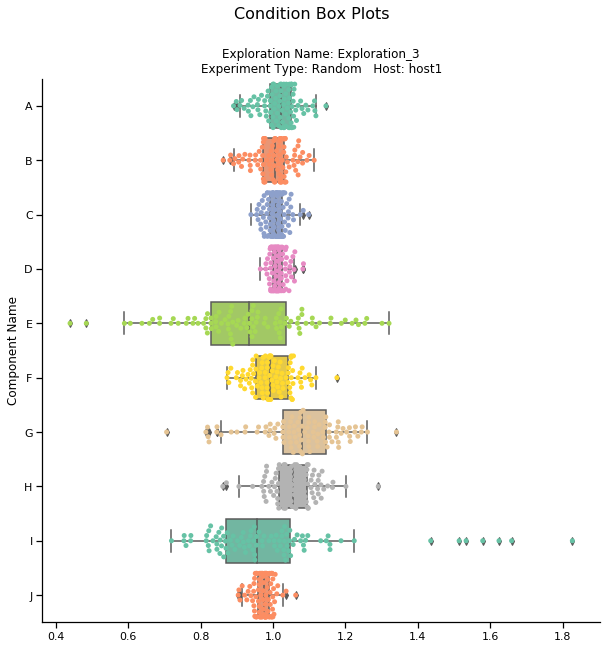

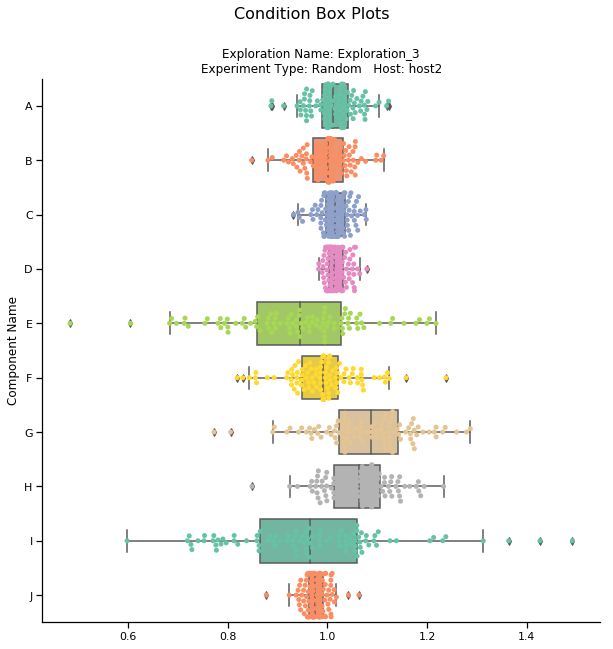

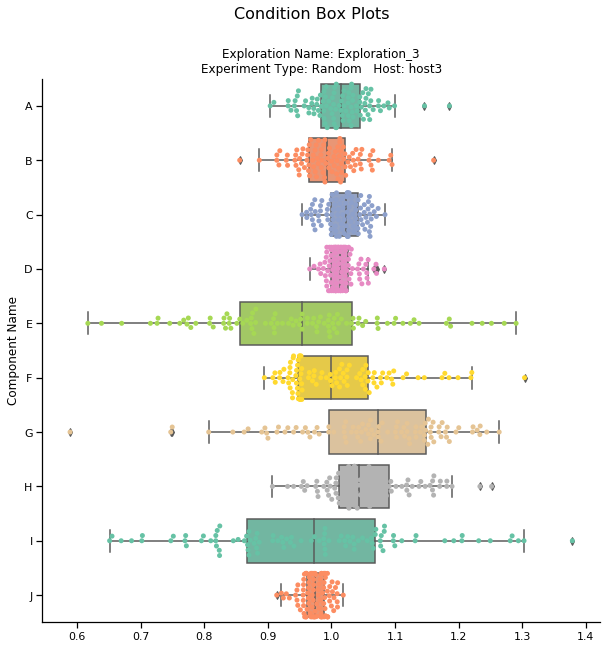

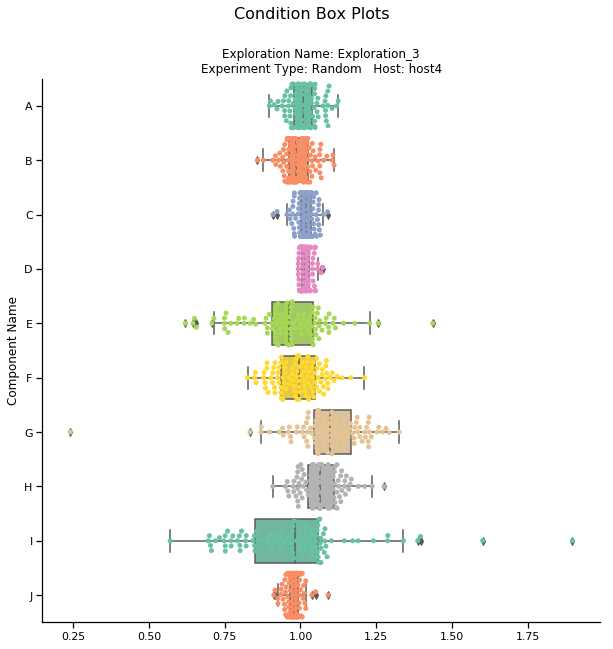

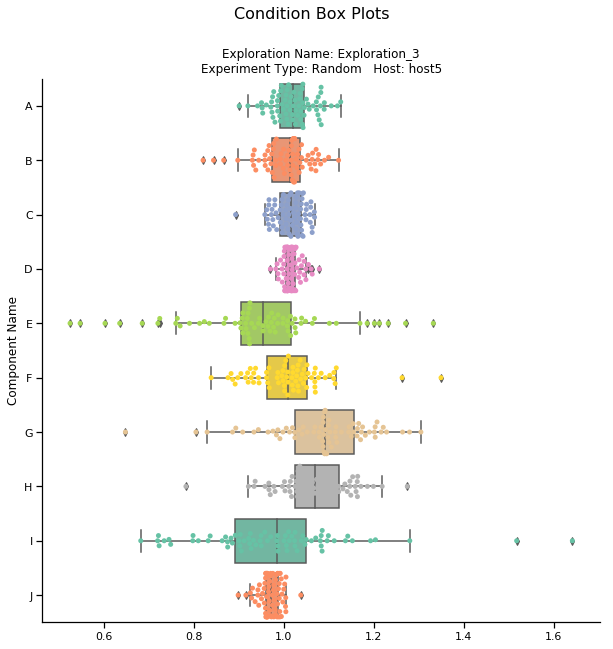

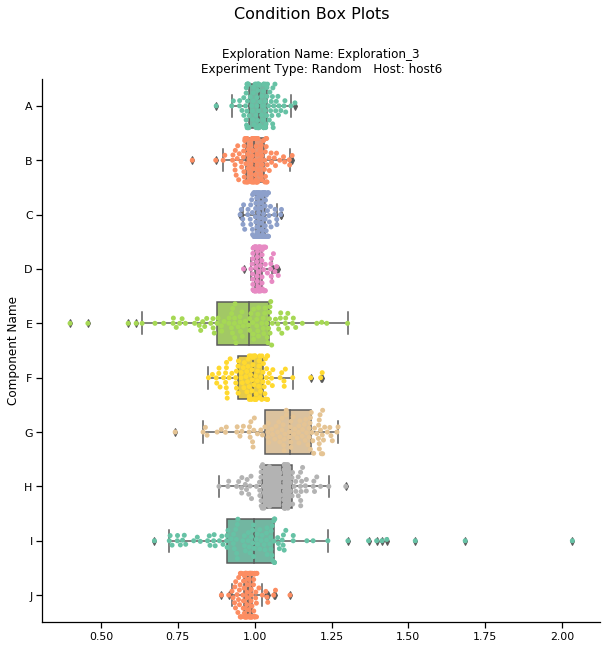

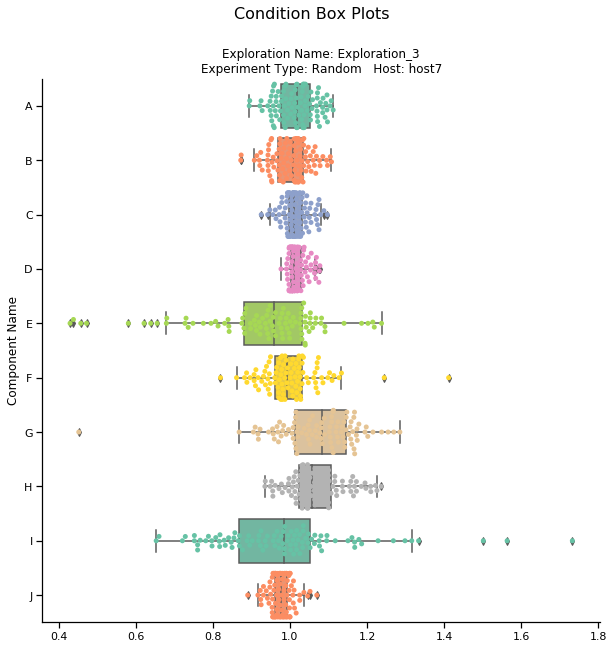

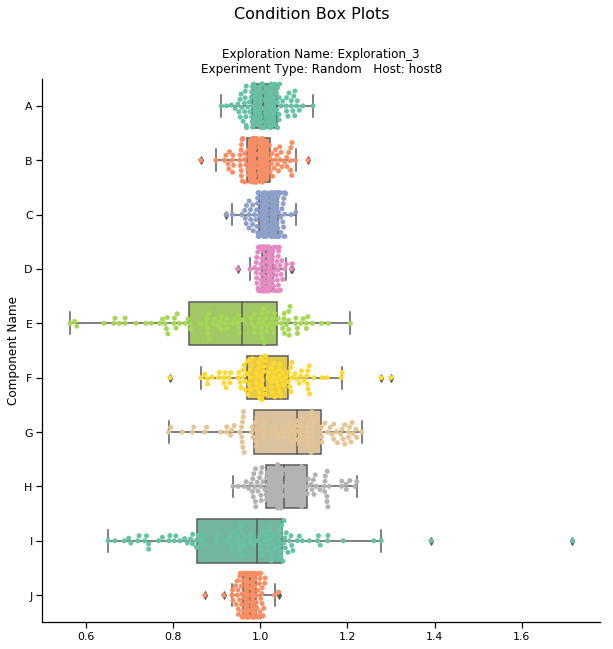

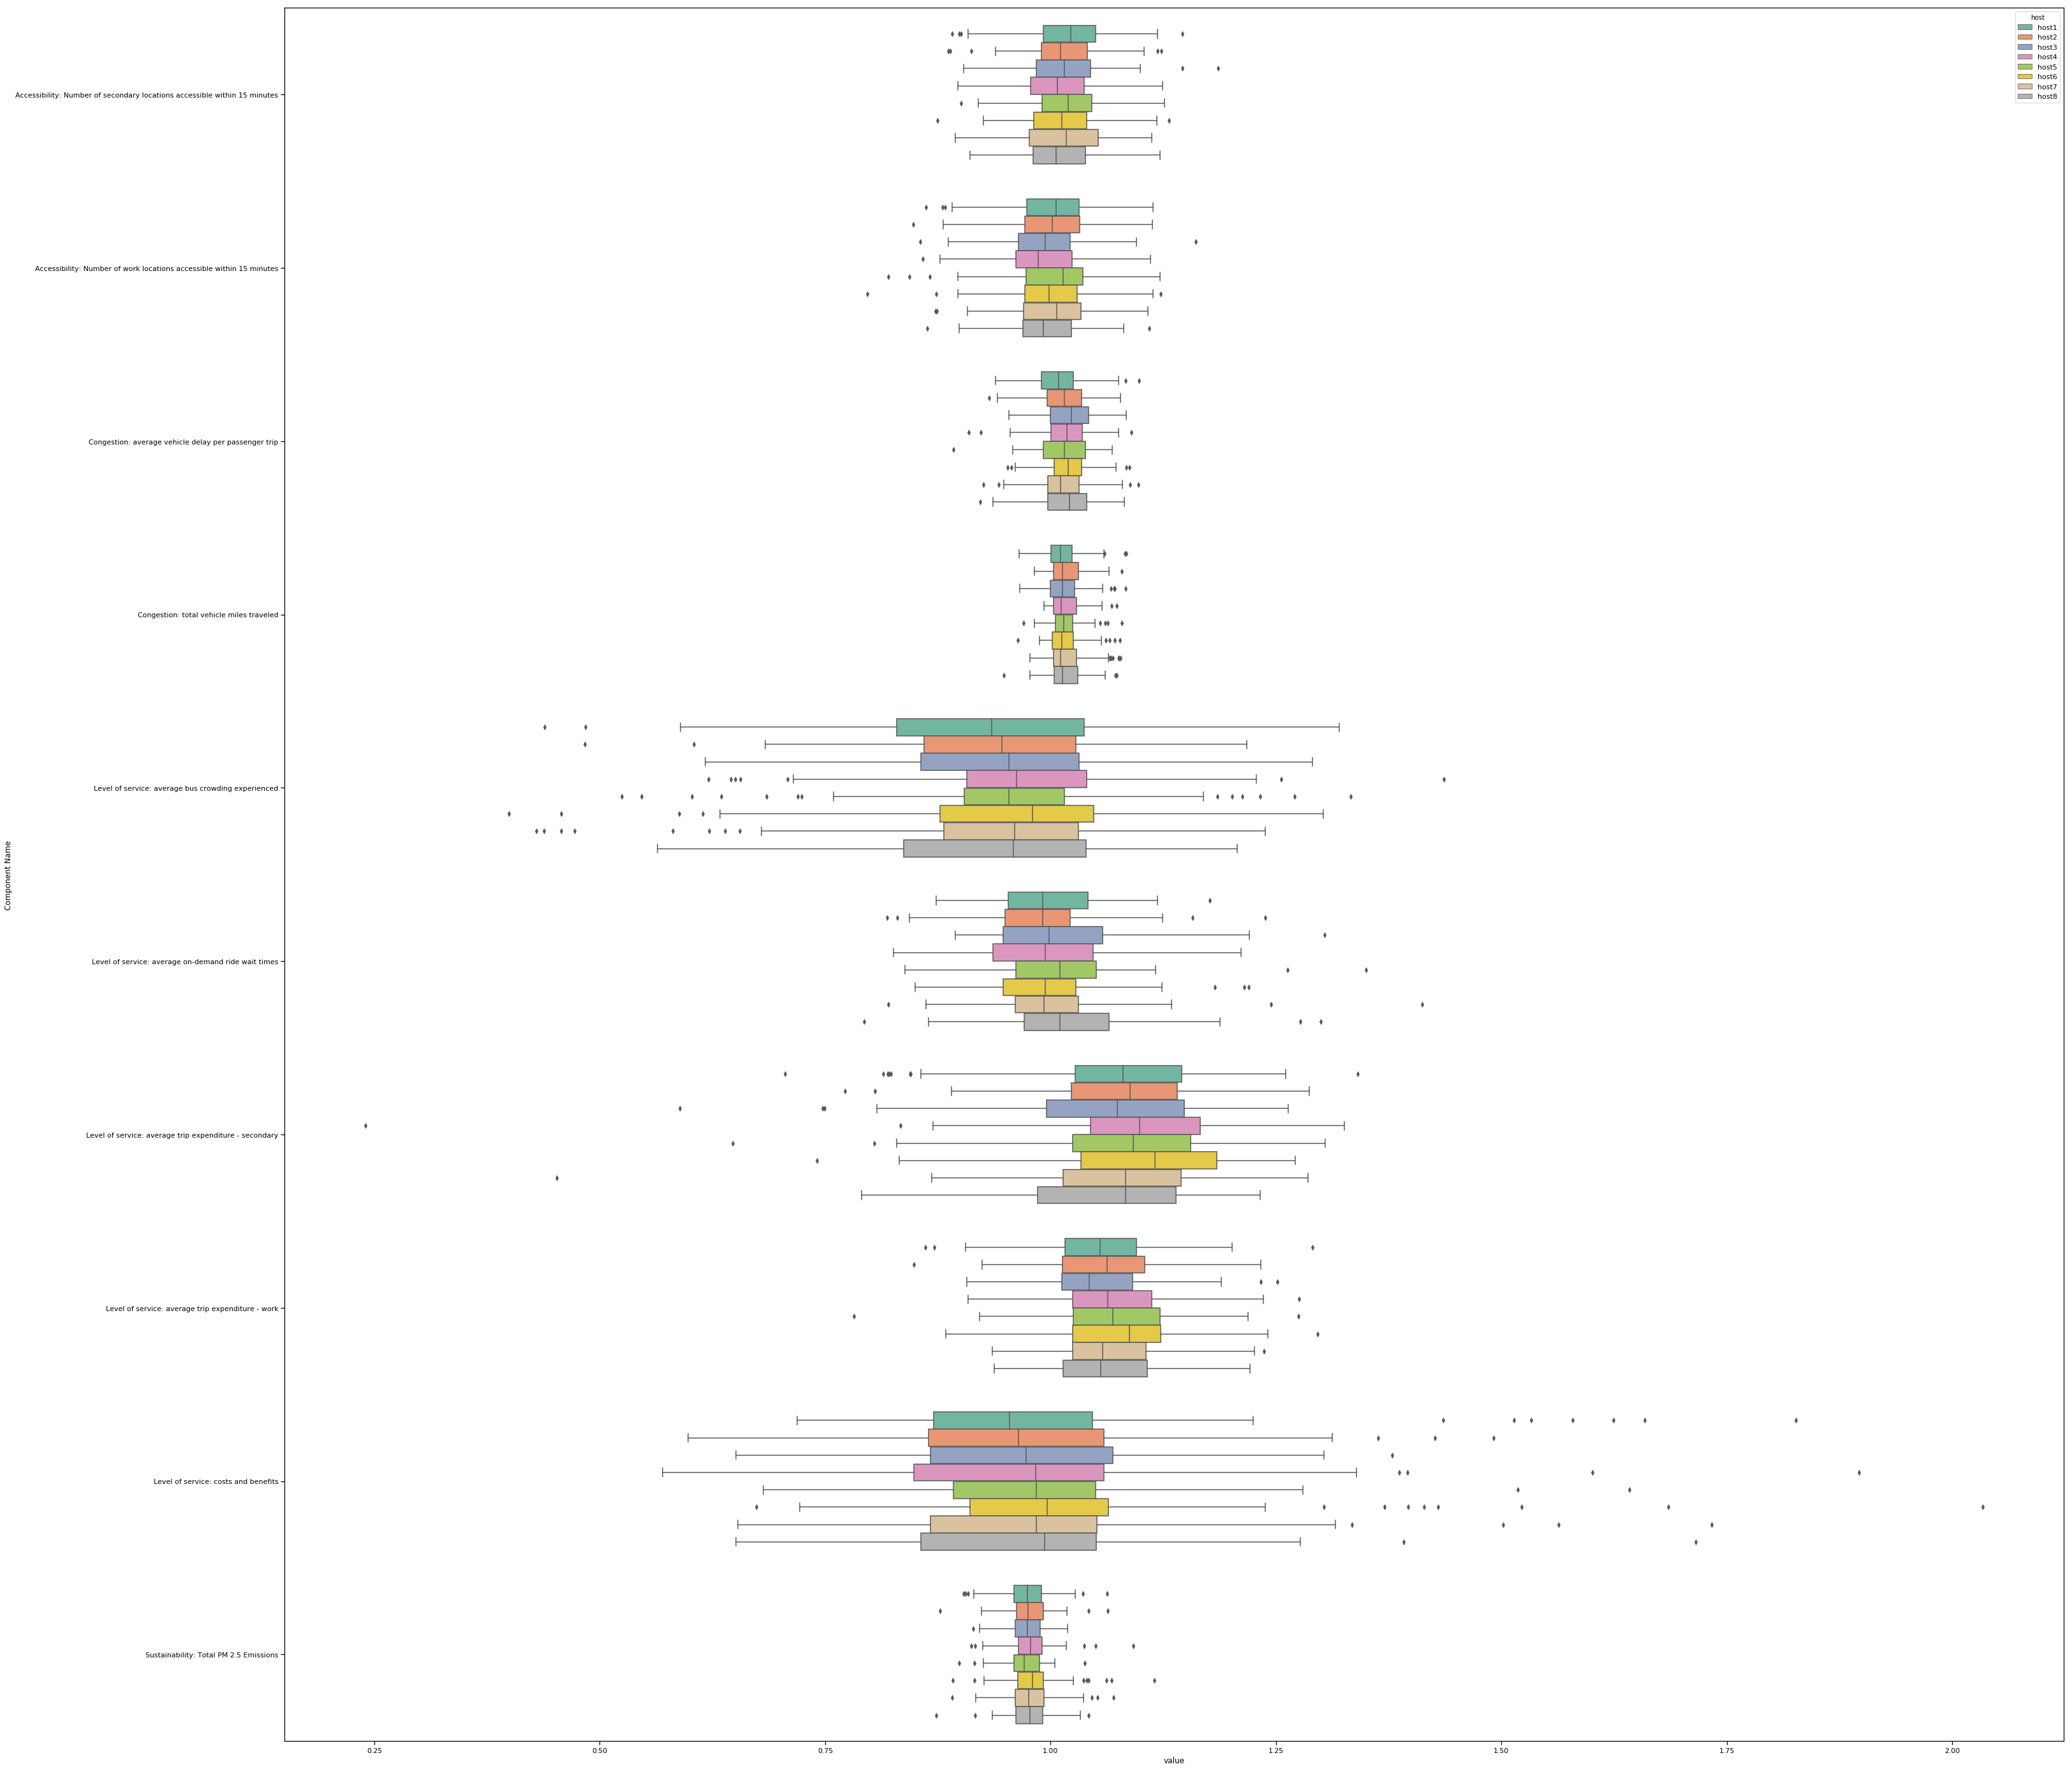

In [698]:
# collect, parse, and concatenate scores as well as plot by condition
import glob
experiment_types = ['random']
exploration_name = 'Exploration_3'
wide_score_dfs = []
for experiment_type in experiment_types:
    i = 0
    scores_dfs={}
    for host in sorted(hosts.keys()):
        

            common="../search-output/{}/{}/{}/".format(exploration_name,experiment_type,host)
            output_dirs = glob.glob(common+"output*/sioux_faux/sioux_faux-15k*/competition/")


            sub_score_dfs = []
            all_input_dfs = defaultdict(list)
            SUBMISSION_INPUTS_DIR_NAME = "submission-inputs/"
            SUB_SCORE_NAME = "submissionScores.csv"
            input_names = ("FrequencyAdjustment","ModeIncentives","MassTransitFares","VehicleFleetMix")
            try:
                for output_dir in output_dirs:
                    # Load sub_score_dfs
                    sub_score_file = output_dir + SUB_SCORE_NAME
                    if not Path(sub_score_file).is_file():
                        continue
                    score_df = pd.read_csv(sub_score_file,index_col="Component Name")
                    output_key = re.findall("^.*output[_|-](.*?)(?:/sioux.*)$",output_dir)[0]
                    if "RS" not in output_key:  # filter out old runs for now
                        continue
                    score_df.loc[:,"output_key"] = output_key
                    sub_score_dfs.append(score_df[["Raw Score","output_key"]])

                    for input_name in input_names:
                        input_file = output_dir + SUBMISSION_INPUTS_DIR_NAME +"/"+ input_name+".csv"
                        if input_name == 'ModeIncentives':
                            input_df = pd.read_csv(input_file,dtype={'age':str})
                        else:
                            input_df = pd.read_csv(input_file)
                        if input_df.shape[0] == 0:
                            continue
                        input_df.loc[:,"output_key"] = output_key
                        input_df.index.name = 'obs_num'
                        all_input_dfs[input_name].append(input_df)
            except ValueError as e:
                print(e)
                print(host)
            freq_df = concat_and_set_index(all_input_dfs,"FrequencyAdjustment").drop('exact_times',axis=1)
            mode_df = concat_and_set_index(all_input_dfs,"ModeIncentives")
            ptfare_df = concat_and_set_index(all_input_dfs,"MassTransitFares")
            vfm_df = concat_and_set_index(all_input_dfs,"VehicleFleetMix").drop("agencyId",axis=1)

            trip_id_factors = pd.factorize(freq_df.loc[:,"route_id"])
            freq_df.loc[:,"route_id"]=trip_id_factors[0]

            mode_factors = pd.factorize(mode_df.loc[:,"mode"])
            mode_df.loc[:,"mode"]=mode_factors[0]

            a,b = pd.factorize(list(set(ptfare_df.loc[:, "routeId"].values).union(set(ptfare_df.loc[:,"routeId"]))))
            mapping = dict(zip(b,a))
            ptfare_df.loc[:,"routeId"]=ptfare_df.loc[:,"routeId"].apply(lambda x: mapping[x])
            vfm_df.loc[:, "routeId"] = vfm_df.loc[:, "routeId"].apply(lambda x: mapping[x])

            vehicle_type_factors = pd.factorize(vfm_df.loc[:,"vehicleTypeId"])
            vfm_df.loc[:,"vehicleTypeId"] = vehicle_type_factors[0]

            input_type = "ModeIncentives"
            input_fields = ["income","age"]
            mode_df = split_input_range(mode_df.copy(),input_fields)

            input_type = "MassTransitFares"
            input_fields = ["age"]
            ptfare_df = split_input_range(ptfare_df.copy(),input_fields)

            scores_df = pd.concat(sub_score_dfs)

            score_type = "Submission Score"
            freq_subscore_df = merge_input_type_df_with_score(freq_df,scores_df,score_type)
            mode_subscore_df = merge_input_type_df_with_score(mode_df,scores_df,score_type)
            ptfare_subscore_df = merge_input_type_df_with_score(ptfare_df,scores_df,score_type)
            vfm_subscore_df = merge_input_type_df_with_score(vfm_df,scores_df,score_type)

            freq_subscore_df=freq_subscore_df[freq_subscore_df["Raw Score"]>0]
            scores_df_wide = scores_df.reset_index().pivot(index='output_key',columns='Component Name',values='Raw Score')
            scores_dfs[host] = scores_df_wide
            fig = plt.figure(figsize=(10,10))
            
            # For plotting:
            
            sns.boxplot(data=scores_df_wide.drop("Submission Score",axis=1),orient='h',palette='Set2')
            sns.swarmplot(data=scores_df_wide.drop("Submission Score",axis=1),orient='h',palette='Set2',color=".25")
            axis = fig.axes[0]
        #     axis.set_xlim(-0.25,5.0)
            plt.suptitle('Condition Box Plots',fontsize=16)
            plt.title("Exploration Name: {}\nExperiment Type: {}   Host: {}".format(exploration_name, experiment_type.title(),host))
            axis.set_yticklabels(['A','B','C','D','E','F','G','H','I','J'])
            sns.despine()
            plt.show()

            fig.savefig("img/{}/{}/{}.png".format(exploration_name,experiment_type, host),format="png",dpi=150)
            plt.close()

    for k,df in scores_dfs.items():
        df['host'] = k
    wide_scores = pd.concat(list(scores_dfs.values()),axis=0)
    wide_scores = wide_scores.drop(['Submission Score','host'],axis=1).astype('float')
    wide_scores.to_csv('img/{}/wide-scores_{}_{}.csv'.format(exploration_name,experiment_type,exploration_name,experiment_type))

    # Plot the full distribution across worker nodes
    grouped = pd.concat(list(scores_dfs.values()))
    melted=pd.melt(grouped.drop("Submission Score",axis=1),id_vars='host')
    fig = plt.figure(figsize=(50,50))

    sns.boxplot(y='Component Name',x='value',hue='host',data=melted,orient='h',palette='Set2')
    fig.savefig('img/{}/{}/grouped.png'.format(exploration_name,experiment_type),dpi=300)
    
    wide_score_dfs.append(wide_scores)


In [557]:
wide_scores = pd.concat(wide_score_dfs,axis=0)
wide_scores.iloc[:,:2]=np.reciprocal(wide_scores.iloc[:,:2])
wide_scores['Level of service: costs and benefits'] = np.reciprocal(wide_scores['Level of service: costs and benefits'])

In [699]:
import pandas as pd, numpy as np
# wide_scores = pd.read_csv("img/random/wide-scores_random.csv")
wide_scores.describe()

Component Name,Accessibility: Number of secondary locations accessible within 15 minutes,Accessibility: Number of work locations accessible within 15 minutes,Congestion: average vehicle delay per passenger trip,Congestion: total vehicle miles traveled,Level of service: average bus crowding experienced,Level of service: average on-demand ride wait times,Level of service: average trip expenditure - secondary,Level of service: average trip expenditure - work,Level of service: costs and benefits,Sustainability: Total PM 2.5 Emissions
count,757.000000,757.000000,757.000000,757.000000,757.000000,757.000000,757.000000,757.000000,757.000000,757.000000
mean,1.014347,0.998325,1.015437,1.016730,0.941853,1.001683,1.076989,1.064483,0.983201,0.976100
std,0.046724,0.049054,0.029899,0.020460,0.148716,0.074844,0.112883,0.068896,0.176750,0.025865
min,0.874776,0.796943,0.892558,0.948301,0.399123,0.792957,0.239905,0.782033,0.569831,0.872905
25%,0.982674,0.967710,0.997332,1.002542,0.866672,0.950524,1.018012,1.018380,0.869355,0.961590
50%,1.013814,1.000397,1.015955,1.012559,0.953981,0.997895,1.089531,1.059819,0.982467,0.975657
75%,1.044608,1.030175,1.035291,1.027968,1.033955,1.043437,1.154849,1.108538,1.058590,0.990941
max,1.185485,1.160658,1.098238,1.083971,1.435912,1.411849,1.340877,1.296300,2.033698,1.114874


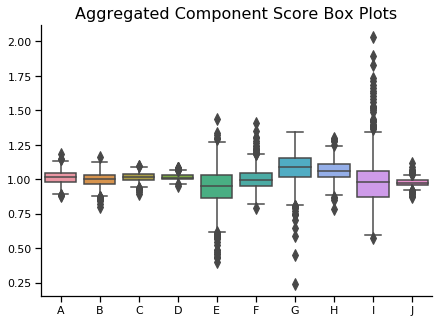

In [700]:
sns.set_context('notebook')
sns.set_palette('Set1')

fig, ax = plt.subplots()
fig.set_size_inches(7,5)
columns = ['A','B','C','D','E','F','G','H','I','J']
ser = []
for i in range(10):
    ser.append(wide_scores.T.iloc[i].values)
sns.boxplot(y=ser,x=columns,orient='v',fliersize=8)
plt.title('Aggregated Component Score Box Plots',fontsize=16)
# plt.title("Random Search over Input Space")
sns.despine()


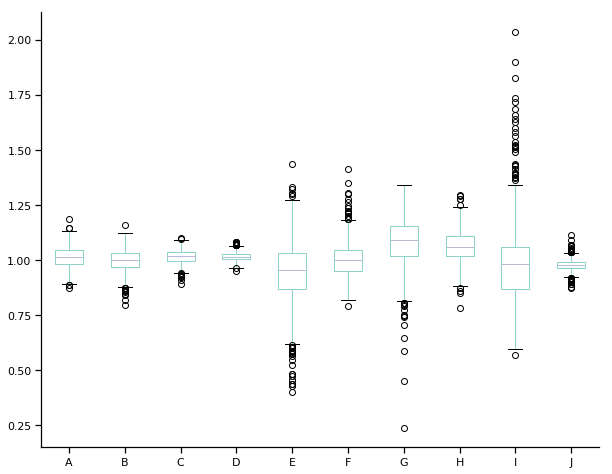

In [701]:
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
sns.set_palette('Set3')
sns.despine()
pd.DataFrame(dict(zip(columns,ser))).plot(kind='box',ax=ax)
fig.savefig('img/{}/{}/aggregate_box.png'.format(exploration_name,experiment_type),dpi=300)

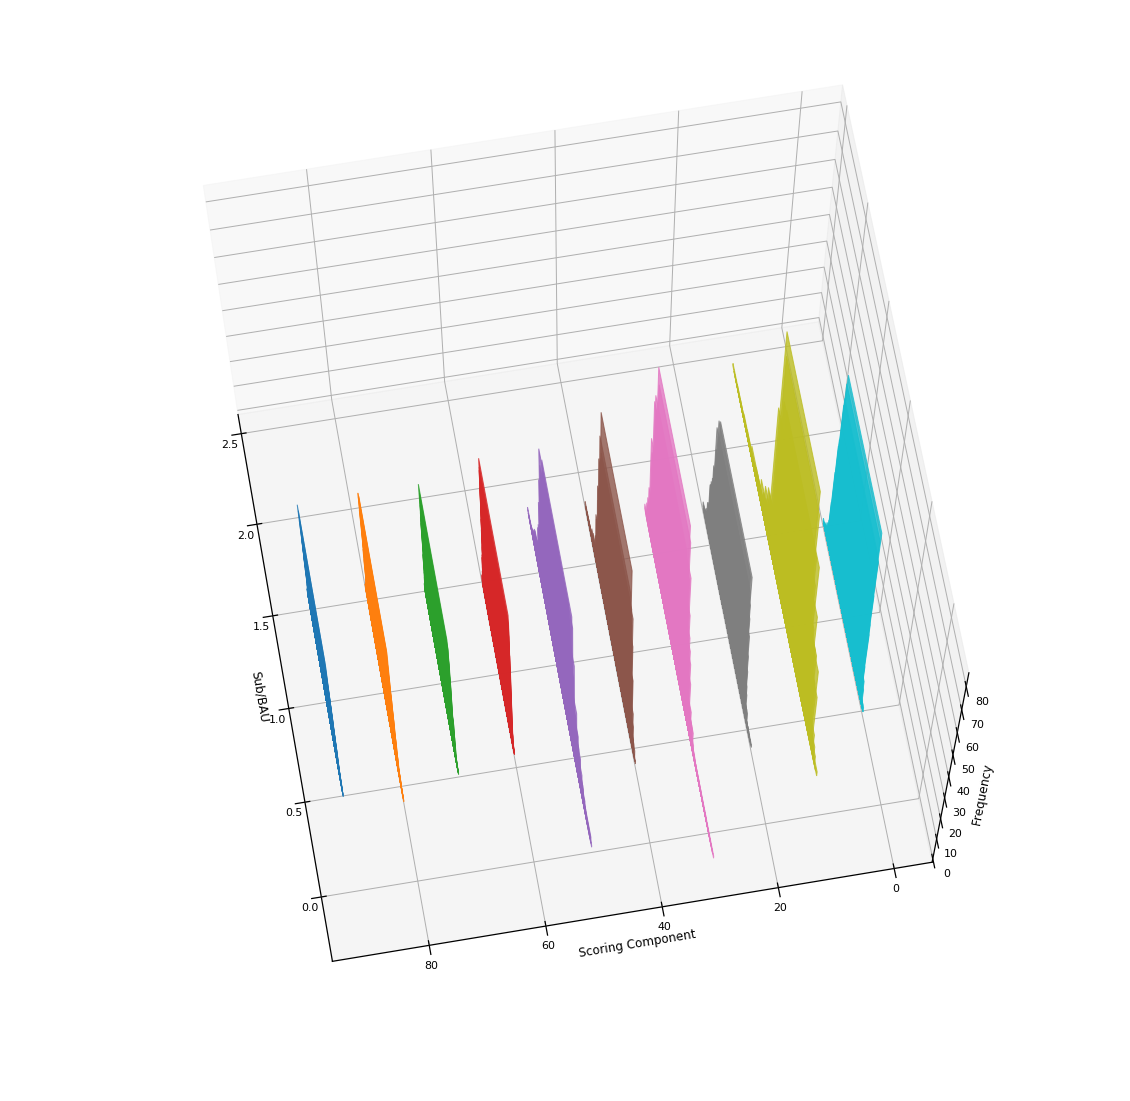

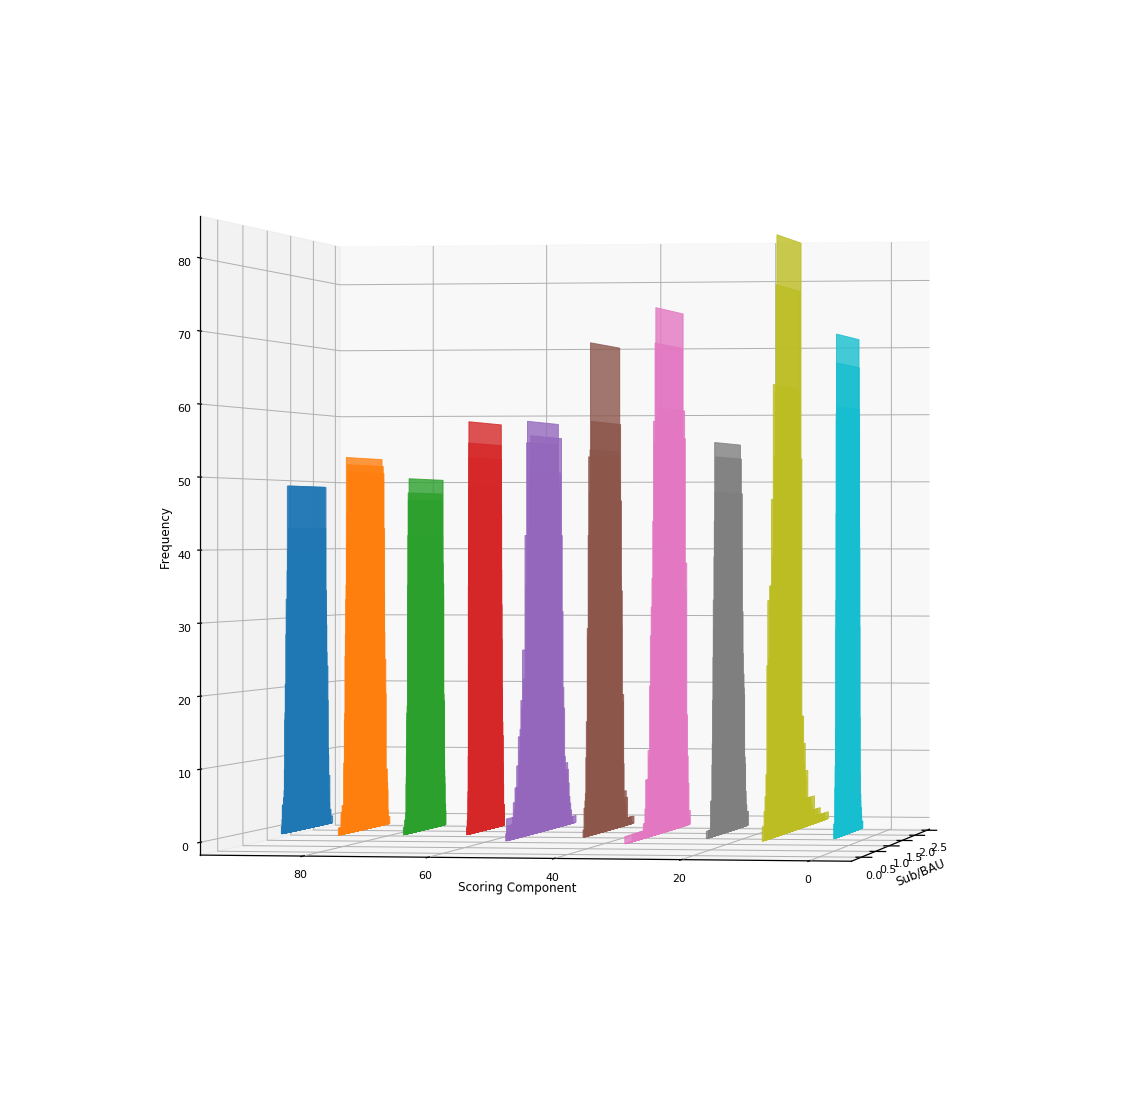

In [702]:
colors = sns.color_palette("tab10",10)



views = [(70,170),(0,190)]

for m,n in enumerate(views):
    fig = plt.figure(num=m,figsize=(20,20))
    ax = fig.add_subplot(1,1,1, projection='3d')
    nbins = 50
    for i,z in enumerate([90,80,70,60,50,40,30, 20, 10, 0]):
        ys = wide_scores.T.iloc[i]

        hist, bins = np.histogram(ys, bins=nbins)
        xs = (bins[:-1] + bins[1:])/2

        ax.bar(xs, hist, zs=z, zdir='y', color=colors[i], ec=colors[i], alpha=0.8)

    ax.set_xlabel('Sub/BAU')
    ax.set_ylabel('Scoring Component')
    ax.set_zlabel('Frequency')

# ax.set_yticklabels(['A','B','C','D','E','F','G','H','I','J'])

    ax.view_init(n[0], n[1])
    plt.show()



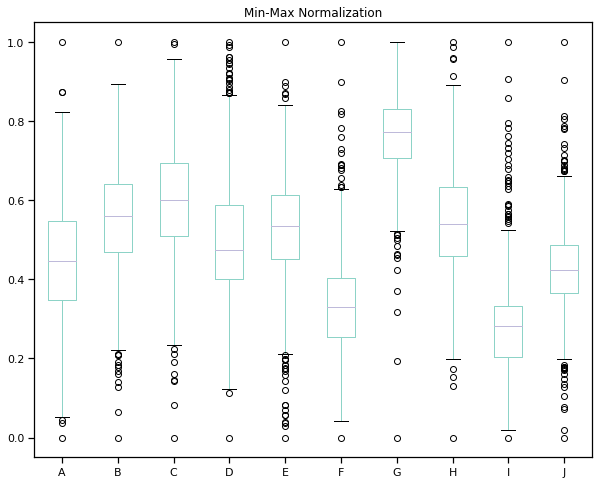

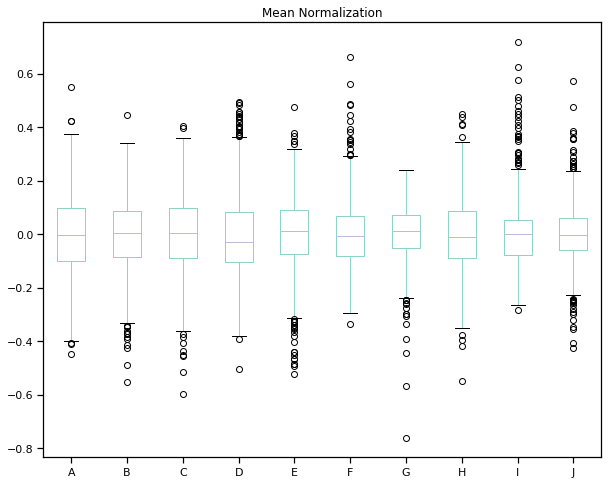

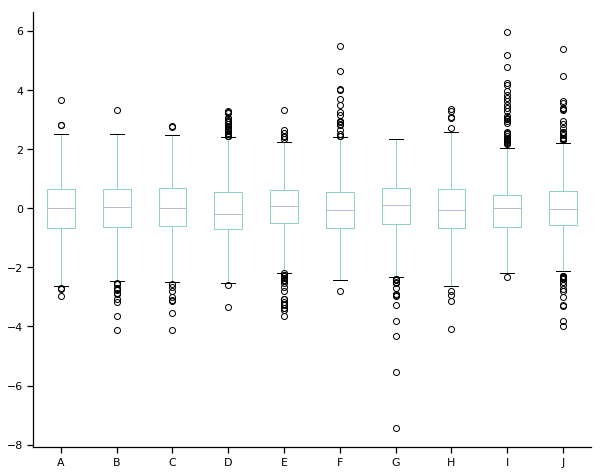

In [703]:
columns = ['A','B','C','D','E','F','G','H','I','J']
mins = np.nanmin(wide_scores.values.astype(float),axis=0)
maxs = np.nanmax(wide_scores.values.astype(float),axis=0)
denom = maxs-mins
means = np.nanmean(wide_scores.values,axis=0)
variances = wide_scores.values.var(axis=0)
stds = wide_scores.values.std(axis=0)

# min-max normalization
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
sns.set_palette('Set3')
pd.DataFrame((wide_scores.values-mins)/denom,columns=columns).plot(kind='box',title='Min-Max Normalization',ax=ax)
plt.savefig('img/min_max_norm.png',format='png',dpi=150)
plt.show()

# mean normalization
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
sns.set_palette('Set3')
pd.DataFrame((wide_scores.values-means)/denom,columns=columns).plot(kind='box',title='Mean Normalization',ax=ax)
plt.savefig('img/mean_norm.png',format='png',dpi=150)
plt.show()

# standardization
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
sns.set_palette('Set3')
pd.DataFrame(((wide_scores.values-means)/stds),columns=columns).plot(kind='box',ax=ax)
sns.despine()
plt.savefig('img/standardization.png',format='png',dpi=150)
plt.show()

In [704]:
dict(zip(columns,wide_scores.columns.values))

{'A': 'Accessibility: Number of secondary locations accessible within 15 minutes',
 'B': 'Accessibility: Number of work locations accessible within 15 minutes',
 'C': 'Congestion: average vehicle delay per passenger trip',
 'D': 'Congestion: total vehicle miles traveled',
 'E': 'Level of service: average bus crowding experienced',
 'F': 'Level of service: average on-demand ride wait times',
 'G': 'Level of service: average trip expenditure - secondary',
 'H': 'Level of service: average trip expenditure - work',
 'I': 'Level of service: costs and benefits',
 'J': 'Sustainability: Total PM 2.5 Emissions'}

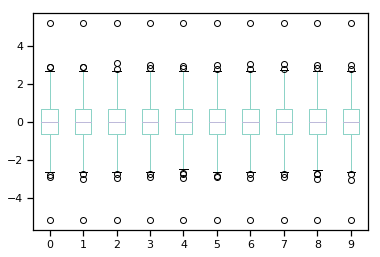

In [705]:
from sklearn.preprocessing import *
transformer = QuantileTransformer(output_distribution='normal')
fitted = transformer.fit(wide_scores.values)
pd.DataFrame(fitted.transform(wide_scores.values)).plot(kind='box')



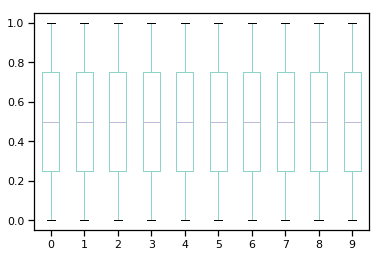

In [706]:
transformer = QuantileTransformer(output_distribution='uniform')
fitted = transformer.fit(wide_scores.values)
pd.DataFrame(fitted.transform(wide_scores.values)).plot(kind='box')

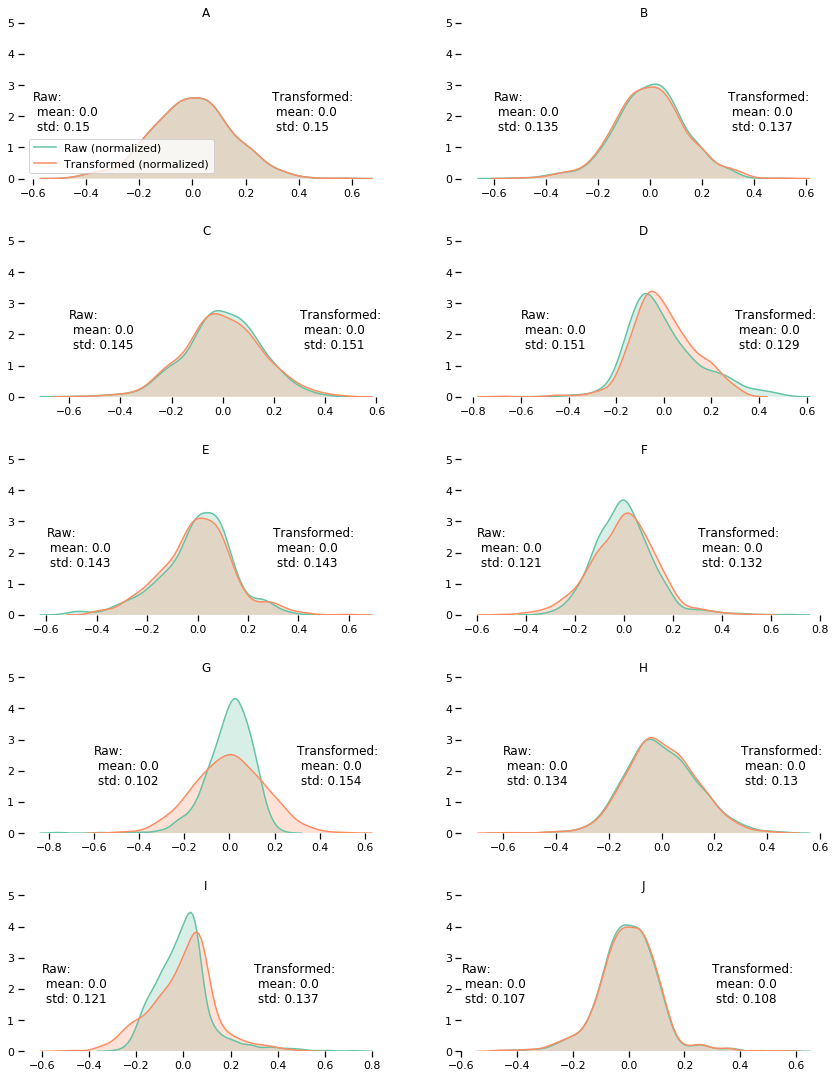

In [708]:
import scipy.stats as ss
sns.set_palette('Set2')

fig,axes=plt.subplots(5,2,figsize=(12,15))
fig.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.4)

i = 0
for m in range(5):
    for n in range(2):
        ax = axes[m][n]
        x = wide_scores.T.iloc[i].values
        xt, maxlog, interval=ss.boxcox(x,alpha=0.05)

        x1=x.reshape(x.shape[0])
        x1=(x1 - x1.mean()) / (x1.max() - x1.min())

        xt1=xt.reshape(x.shape[0])
        xt1=(xt1 - xt1.mean()) / (xt1.max() - xt1.min())

        sns.kdeplot(x1, shade=True, label="Raw (normalized)" ,ax=ax);
        sns.kdeplot(xt1, shade=True, label="Transformed (normalized)" ,ax=ax);
        ax.set_frame_on(False)
        ax.set_title(columns[i])
        ax.set_ylim(0.0,5.0)
        ax.annotate('Raw:\n mean: 0.0\n std: {:.3}'.format(x1.std()),(-0.6,1.55))
        ax.annotate('Transformed:\n mean: 0.0\n std: {:.3}'.format(xt1.std()),(0.3,1.55))
        if i!=0:
            ax.get_legend().remove()
        else:
            ax.legend(loc='lower left')
        i+=1
#             plt.show()

In [709]:
def make_subset_score_df(fn, score_df):
    subset_score_series = score_df.iloc[fn(score_df.values,0)]
    worst_score_names = pd.Series(dict(zip(subset_score_series.columns.values.tolist(),subset_score_series.index.values.tolist())))
    worst_score_values = pd.Series(dict(zip(subset_score_series.columns.values.tolist(),np.diag(subset_score_series.values.tolist()))))
    df=pd.DataFrame({"Sample Names":worst_score_names,"Score Values":worst_score_values})
    return df

In [710]:
worst_scores = make_subset_score_df(np.argmax,wide_scores)
worst_scores

,Sample Names,Score Values
Accessibility: Number of secondary locations accessible within 15 minutes,C9_RS19-48jjy04o,1.185485
Accessibility: Number of work locations accessible within 15 minutes,C9_RS19-48jjy04o,1.160658
Congestion: average vehicle delay per passenger trip,C9_RS56-tegn6rrv,1.098238
Congestion: total vehicle miles traveled,C9_RS96-2630unkg,1.083971
Level of service: average bus crowding experienced,C9_RS69-kuy0sbpg,1.435912
Level of service: average on-demand ride wait times,C9_RS35-ov_a5c_d,1.411849
Level of service: average trip expenditure - secondary,C9_RS93-iv7m1c1v,1.340877
Level of service: average trip expenditure - work,C9_RS4-hjz52c44,1.296300
Level of service: costs and benefits,C9_RS94-m3nq38be,2.033698
Sustainability: Total PM 2.5 Emissions,C9_RS92-33mdiv6u,1.114874


In [711]:
best_scores = make_subset_score_df(np.argmin,wide_scores)
best_scores

,Sample Names,Score Values
Accessibility: Number of secondary locations accessible within 15 minutes,C9_RS92-33mdiv6u,0.874776
Accessibility: Number of work locations accessible within 15 minutes,C9_RS92-33mdiv6u,0.796943
Congestion: average vehicle delay per passenger trip,C9_RS35-o7upbpfd,0.892558
Congestion: total vehicle miles traveled,C9_RS82-5_5o7s57,0.948301
Level of service: average bus crowding experienced,C9_RS94-m3nq38be,0.399123
Level of service: average on-demand ride wait times,C9_RS63-lpmydqft,0.792957
Level of service: average trip expenditure - secondary,C9_RS91-w46l8hi9,0.239905
Level of service: average trip expenditure - work,C9_RS35-o7upbpfd,0.782033
Level of service: costs and benefits,C9_RS17-270gx9sc,0.569831
Sustainability: Total PM 2.5 Emissions,C9_RS82-5_5o7s57,0.872905


In [712]:
sample1_key = "C9_RS17-270gx9sc" # host4
sample2_key = "C9_RS5-b0n_9dqy"  # host8

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


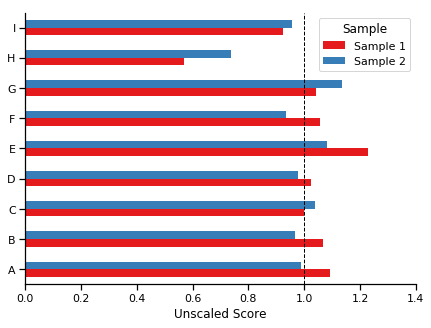

In [713]:
sns.set_context('notebook')
sns.set_palette('Set1')
fig, ax = plt.subplots()
fig.set_size_inches(7,5)

sample1 = pd.Series(dict(zip(wide_scores.columns.tolist(),np.squeeze(wide_scores.loc[sample1_key].values.reshape(1, -1)).tolist())))
sample2 = pd.Series(dict(zip(wide_scores.columns.tolist(),np.squeeze(wide_scores.loc[sample2_key].values.reshape(1, -1)).tolist())))


std_raw_scores = pd.DataFrame({"Sample 1":sample1,"Sample 2":sample2})
# sns.barplot(data=std_raw_scores)
std_raw_scores.index.name="Score Component"
std_raw_scores.columns.name='Sample'
std_raw_scores.drop('Level of service: average on-demand ride wait times',inplace=True)
std_raw_scores.index=['A','B','C','D','E','F','G','H','I']
std_raw_scores.plot(kind='barh',ax=ax)
plt.axvline(x=1.0,linewidth=1, color='k', ls='dashed', label = "baseline")
plt.xlabel("Unscaled Score")
plt.xlim(xmax = 1.4)
sns.despine()
plt.savefig('img/random_inputs/unscaled_sample_scores.png',format='png',dpi=150,bbox_inches="tight")

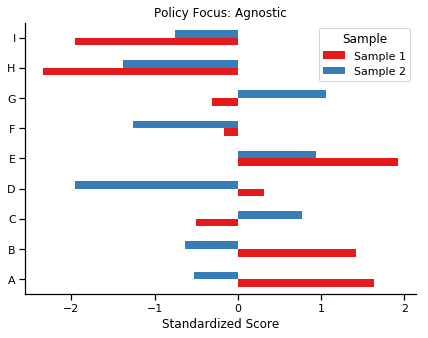

In [714]:
sns.set_context('notebook')
sns.set_palette('Set1')
fig, ax = plt.subplots()
fig.set_size_inches(7,5)


sc_fit = StandardScaler().fit(wide_scores.values)
sample1 = pd.Series(dict(zip(wide_scores.columns.tolist(),np.squeeze(sc_fit.transform(wide_scores.loc[sample1_key].values.reshape(1, -1))).tolist())))
sample2 = pd.Series(dict(zip(wide_scores.columns.tolist(),np.squeeze(sc_fit.transform(wide_scores.loc[sample2_key].values.reshape(1, -1))).tolist())))

# flip accessibility:
# sample1.iloc[0:2]=np.reciprocal(sample1.iloc[0:2])

std_raw_scores = pd.DataFrame({"Sample 1":sample1,"Sample 2":sample2})
# sns.barplot(data=std_raw_scores)
std_raw_scores.index.name="Score Component"
std_raw_scores.columns.name='Sample'
std_raw_scores.drop('Level of service: average on-demand ride wait times',inplace=True)
std_raw_scores.index=['A','B','C','D','E','F','G','H','I']
std_raw_scores.plot(kind='barh',ax=ax)
# plt.axvline(x=1.0,linewidth=1, color='k', ls='dashed', label = "baseline")
plt.xlabel("Standardized Score")
ax.set_title('Policy Focus: Agnostic')
# plt.xlim(right = 0.7,left=-0.7)

sns.despine()
plt.savefig('img/random_inputs/Policy Agnostic_standardized_scores.png',format='png',dpi=150,bbox_inches="tight")
# plt.xlim(xmax = 1.4)

In [822]:
wt_df = pd.read_csv('policy_weights.csv',index_col=0)

In [716]:
sample1.drop('Level of service: average on-demand ride wait times',inplace=True)
sample2.drop('Level of service: average on-demand ride wait times',inplace=True)

In [823]:
wt_norm = (wt_df.T/wt_denom).T
sample1_wt = wt_norm*sample1
sample2_wt = wt_norm*sample2

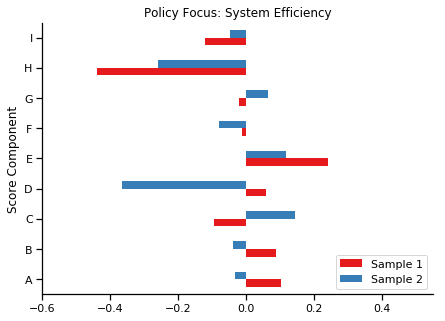

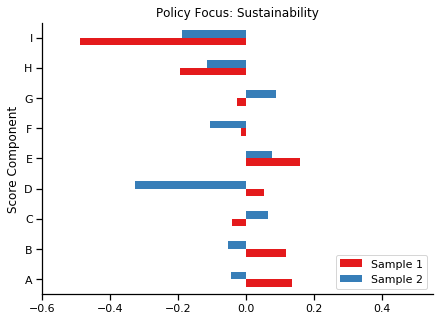

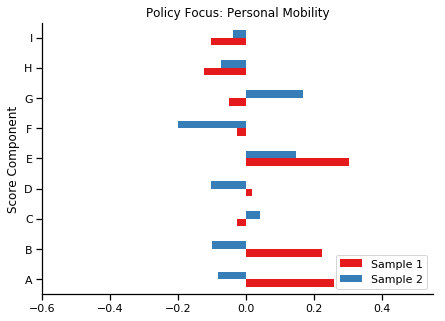

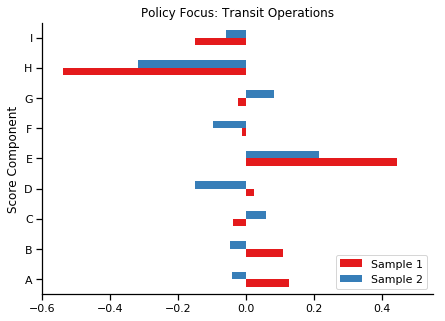

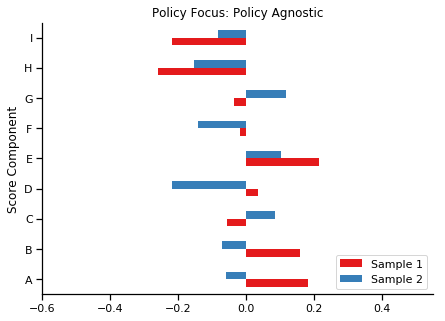

In [725]:
dfs = []

for policy in sample1_wt.index.values:
    sns.set_context('notebook')
    sns.set_palette('Set1')
    fig, ax = plt.subplots()
    fig.set_size_inches(7,5)
    std_wt_scores = pd.DataFrame({"Sample 1":sample1_wt.loc[policy].T,"Sample 2":sample2_wt.loc[policy].T})

    std_wt_scores.index=['A','B','C','D','E','F','G','H','I']
    std_wt_scores.index.name="Score Component"
    std_wt_scores.columns.name='Sample'
    dfs.append(std_wt_scores)
    std_wt_scores.plot(kind='barh',ax=ax)
    ax.set_title('Policy Focus: {}'.format(policy.title()))
    plt.xlim(right = 0.55,left=-0.6)
    sns.despine()
    plt.legend(loc='lower right')
    plt.savefig('img/random_inputs/{}_standardized_sample_scores.png'.format(policy),format='png',dpi=150,bbox_inches="tight")

In [808]:
leg = axes[-1][-1].legend('best')
leg?

In [830]:
wt_norm.shape[0]

5

In [ ]:
wt_norm.iloc[]

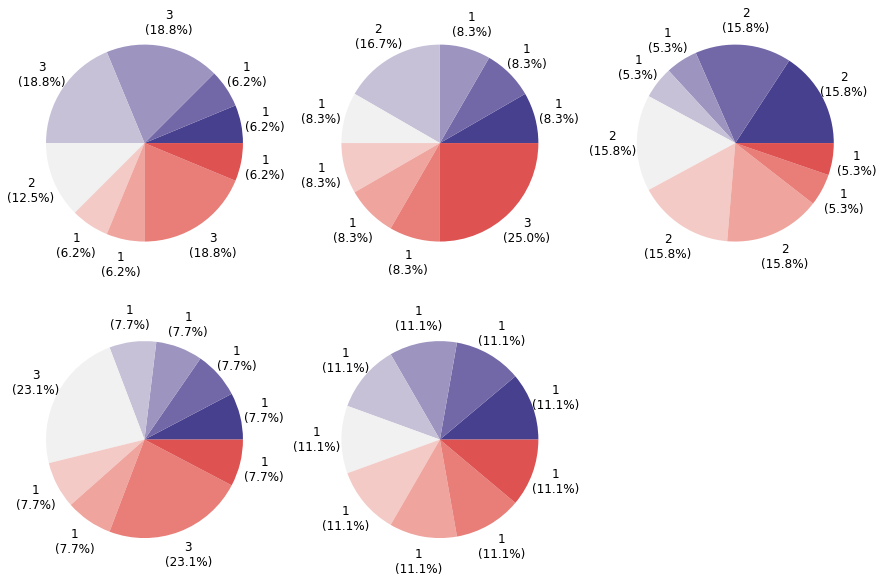

In [878]:
import matplotlib.patches as mpatches


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:d}\n({:.1f}%)".format(absolute, pct)


colors=["#46408f",
"#7368a7",
"#9d94c0",
"#c7c1d8",
"#f1f1f1",
"#f3cac6",
'#f0a49e',
'#e97d77',
"#de5252"]

leg_patches = [mpatches.Patch(color=c) for c in colors]
leg_labels = wt_norm.columns.values

leg_iter = zip(leg_patches,leg_labels)

p=0
fig, axes = plt.subplots(2, 3, sharex=True, figsize=(15,10))
for i in range(2):
    for j in range(3):
        ax = axes[i,j]
        if p > 4:

            fig.delaxes(axes[i,j])
            break

            
        ax.pie(x=wt_df.iloc[p],colors=colors, autopct=lambda pct: func(pct, wt_df.iloc[p]),pctdistance=1.25)

        p+=1
        


# axes=wt_df.T.plot.pie(subplots=True,colors=colors,autopct='%.2f', figsize=(15, 10),labels=['A','B','C','D','E','F','G','H','I'],layout=(2,3))
# axes[-1][-1].legend(handles=leg_patches,labels=leg_labels,loc="lower center")


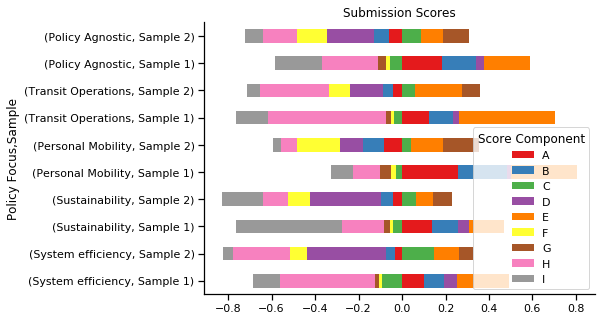

In [753]:
full_df = pd.concat(dfs,axis=1,keys=wt_df.index)
sns.set_context('notebook')
sns.set_palette('Set1')
fig, ax = plt.subplots()
fig.set_size_inches(7,5)
sns.despine()
final_scores = full_df.T.plot.barh(ax=ax,stacked=True)
ax.set_title('Submission Scores')
plt.savefig('img/random_inputs/final_scores.png',format='png',dpi=150,bbox_inches="tight")

In [671]:
df = full_df.T.reset_index().melt(id_vars=['Sample','Policy Focus'])
sns.FacetGrid(df,col='Policy Component')

KeyError: 'Policy Component'

In [508]:
root = "/Users/sfeygi/current_code/others/prize_starter_kit/utilities/policy_inputs"
suff = "/submissionScores.csv"

score_data = {"Increased Bus Frequency" : root+"/increased_bus_frequency"+suff,
"No Transit" : root+"/no_transit"+suff,
"Redistributive: Transit and On-Demand" : root + "/redistributive_transit_on_demand"+suff}

score_dfs = {score_type:pd.read_csv(csv,index_col=0).drop("Submission Score",axis=0)["Raw Score"] for score_type,csv in score_data.items()}


In [509]:
for k,v in score_dfs.items():
    v.loc["Input Policy Type"] = k

In [510]:
policy_scores_df = pd.concat(score_dfs.values(),axis=1,sort=True).T
policy_scores_df = policy_scores_df.set_index("Input Policy Type")
policy_scores = policy_scores_df
policy_scores.iloc[:,:2]=np.reciprocal(policy_scores.iloc[:,:2])
policy_scores['Level of service: costs and benefits'] = np.reciprocal(policy_scores['Level of service: costs and benefits'])
policy_scores = pd.DataFrame(sc_fit.transform(policy_scores),columns=policy_scores.columns,index=policy_scores.index)
policy_scores.drop('Level of service: average on-demand ride wait times',axis=1,inplace=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  


In [511]:
s1 = wt_norm*policy_scores.iloc[0]
s2 = wt_norm*policy_scores.iloc[1]
s3 = wt_norm*policy_scores.iloc[2]

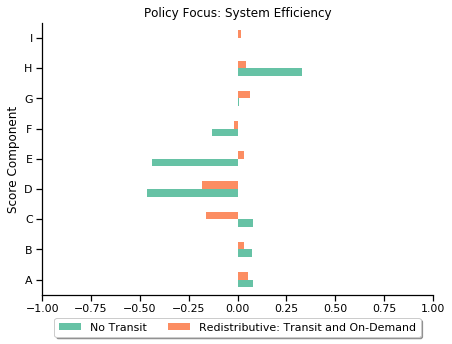

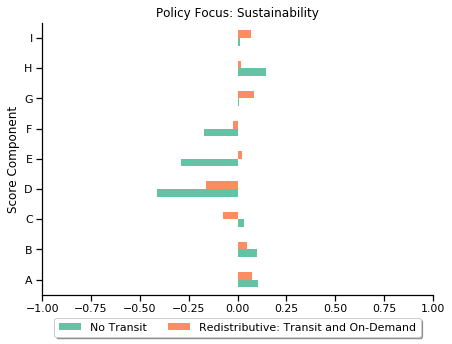

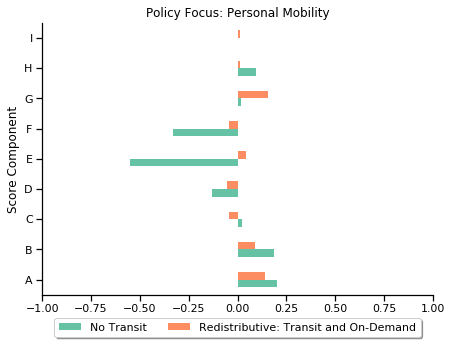

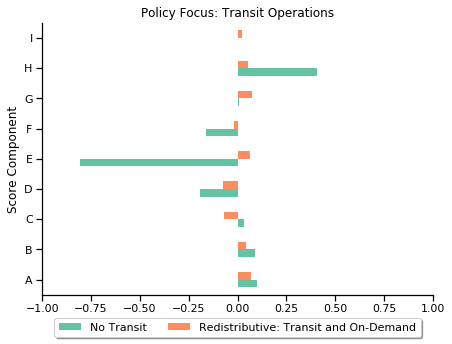

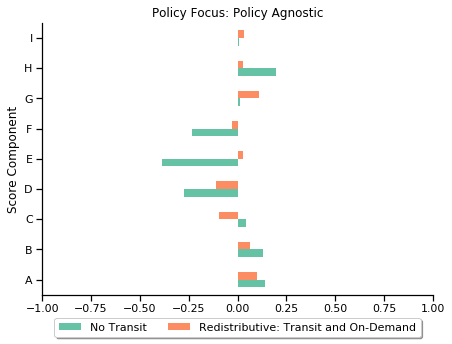

In [512]:
dfs = []
for policy in sample1_wt.index.values:
    sns.set_context('notebook')
    sns.set_palette('Set2')
    fig, ax = plt.subplots()
    fig.set_size_inches(7,5)
    
    std_wt_scores = pd.DataFrame({"No Transit":s2.T[policy],"Redistributive: Transit and On-Demand":s3.T[policy]})
    
    std_wt_scores.index=['A','B','C','D','E','F','G','H','I']
    std_wt_scores.index.name="Score Component"
    std_wt_scores.columns.name='Sample'
    dfs.append(std_wt_scores)
    std_wt_scores.plot(kind='barh',ax=ax,legend=False)
    ax.set_title('Policy Focus: {}'.format(policy.title()))
#     plt.xlim(right = 7,left=-7)
    plt.xlim(right =1,left=-1)
    sns.despine()
#     plt.legend(loc='lower right')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.175),
          ncol=3, fancybox=True, shadow=True)
    plt.savefig('img/policy_inputs/{}_standardized_sample_scores.png'.format(policy),format='png',dpi=150,bbox_inches="tight")


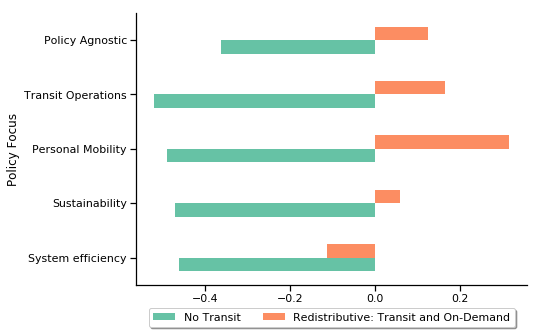

In [513]:
full_df = pd.concat(dfs,axis=1,keys=wt_df.index)
sns.set_context('notebook')
sns.set_palette('Set2')
fig, ax = plt.subplots()
fig.set_size_inches(7,5)
sns.despine()
final_scores = full_df.sum(axis=0).unstack().plot(kind='barh',ax=ax,legend=True)

plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.175),
          ncol=3, fancybox=True, shadow=True)

plt.savefig('img/policy_inputs/final_scores.png',format='png',dpi=150,bbox_inches="tight")